### Test case LVV-T3177: Verify implementation of Image Differencing with single-exposure templates

Verify that the DMS can perform image differencing from single exposures.

In [1]:
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
import lsst.afw.display as afw_display

The tasks to create a template from a single input image ("makeTemplate") and to use that template to create a difference image ("makeDiff") were executed from the command line using the following:

```
pipetask run -b dp2_prep -i LSSTCam/runs/DRP/20250421_20250921/d_2025_11_10/DM-53195 -p singleframe_template_diff.yaml#makeTemplate,makeDiff -o u/jcarlin/single_vis_template2 --instrument lsst.obs.lsst.LsstCam --register-dataset-types -d "skymap='lsst_cells_v2' AND visit IN (2025092100028) AND detector=55 AND instrument='LSSTCam'" 2>&1 | tee singleframe_template_test.log
```

Note that we specified differencing of a single visit (2025092100028) and detector (55).

The pipeline "singleframe_template_diff.yaml" contains the following:

This portion constrains the `selectDeepCoaddVisits` task to select only a single input for the template by setting `nVisitsMax = 1`.

```
  selectDeepCoaddVisits:
    class: lsst.pipe.tasks.selectImages.BestSeeingSelectVisitsTask
    config:
      connections.visitSummaries: preliminary_visit_summary
      nVisitsMax: 1
```

Initialize two Butlers: the one pointing to the user collection from the pipetask execution outlined above, and another from a recent DRP processing run:

In [2]:
repo = 'dp2_prep'
collection = 'u/jcarlin/single_vis_template2'
collection_orig = 'LSSTCam/runs/DRP/20250421_20250921/d_2025_11_10/DM-53195'

butler = Butler(repo, collections=collection)
butler_orig = Butler(repo, collections=collection_orig)

Specify the visit and detector that were used for image differencing:

In [3]:
visit = 2025092100028
detector = 55

Retrieve the `template_coadd` references, and examine one of the overlapping coadd templates.

In [4]:
orig_template_refs = butler_orig.query_datasets('template_coadd',
                                                visit=visit, detector=detector)

new_template_refs = butler.query_datasets('template_coadd',
                                          visit=visit, detector=detector)

In [5]:
orig_template = butler_orig.get(orig_template_refs[6])
new_template = butler.get(new_template_refs[6])

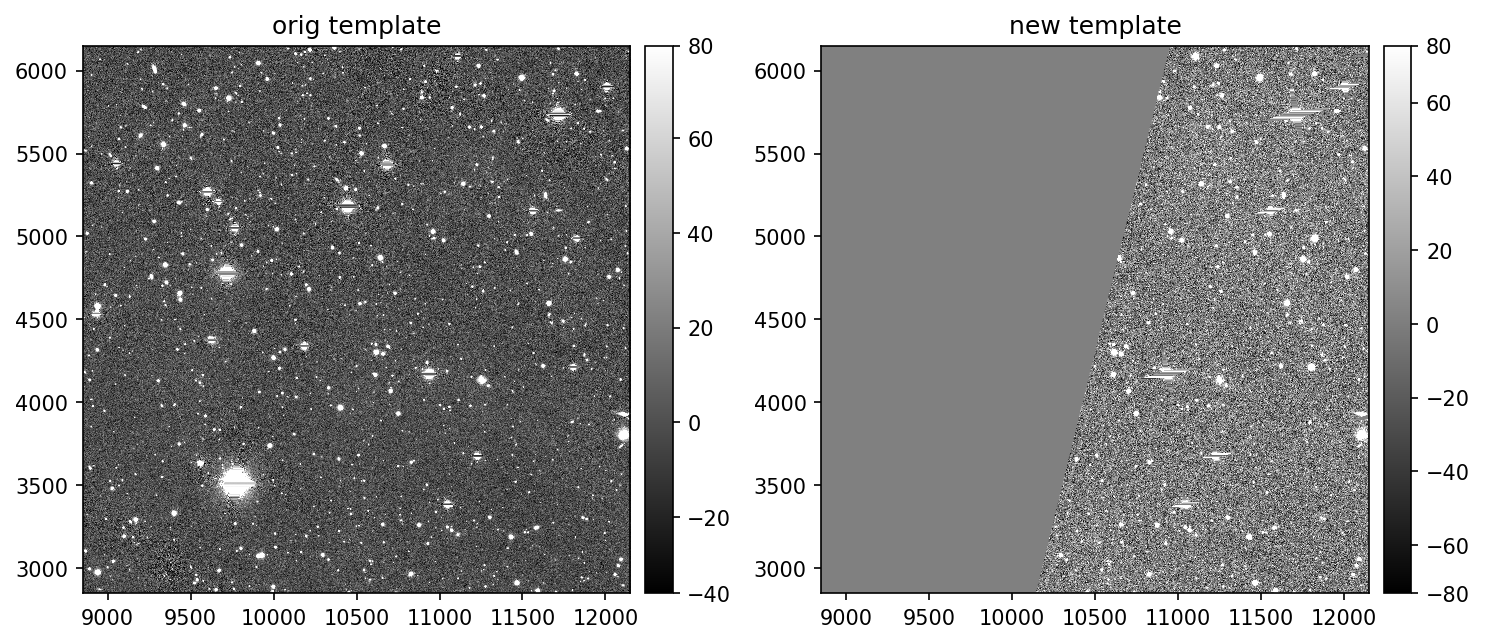

In [6]:
afw_display.setDefaultBackend("matplotlib")

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afw_display.Display(frame=fig)
display0.scale('linear', 'zscale')
display0.mtv(orig_template.image)
plt.title('orig template')

plt.sca(ax[1])
display1 = afw_display.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(new_template.image)
plt.title('new template')

plt.tight_layout()
plt.show()

The "new" (single-visit) template clearly is shallower than the one made from many inputs, and only overlaps a portion of the input image.

Extract the lists of coadd inputs for each of these and examine them:

In [7]:
orig_inputs = orig_template.info.getCoaddInputs()
new_inputs = new_template.info.getCoaddInputs()

In [8]:
print('Original template coadd input CCDs: \n\n', orig_inputs.ccds)

print('\nNew template coadd input CCDs: \n\n', new_inputs.ccds)

Original template coadd input CCDs: 

      id     bbox_min_x bbox_min_y ... goodpix         weight         filter
               pix        pix     ...                                      
----------- ---------- ---------- ... ------- ---------------------- ------
47253120308          0          0 ... 1009272  0.0017223086445651563   i_39
47253120347          0          0 ... 7383519  0.0017223086445651563   i_39
47253120348          0          0 ... 4816406  0.0017223086445651563   i_39
47286717715          0          0 ... 6637071 0.00043297892944404906   i_39
47286717718          0          0 ... 1462589 0.00043297892944404906   i_39
47286717719          0          0 ...  859866 0.00043297892944404906   i_39
47286718057          0          0 ... 5169571  0.0004698727932531459   i_39
47286718058          0          0 ... 5607282  0.0004698727932531459   i_39
47286718096          0          0 ...  895989  0.0004698727932531459   i_39
        ...        ...        ... ...     ...    

We see that the "original" template was created from 33 input images, while the "new" one has only a single input.

Now compare the difference and template images:

In [9]:
orig_diffim_refs = butler_orig.query_datasets('difference_image_predetection',
                                              visit=visit, detector=detector)

new_diffim_refs = butler.query_datasets('difference_image_predetection',
                                        visit=visit, detector=detector)

orig_diffim = butler_orig.get(orig_diffim_refs[0])
new_diffim = butler.get(new_diffim_refs[0])

In [10]:
orig_template_det_refs = butler_orig.query_datasets('template_detector',
                                                    visit=visit, detector=detector)
orig_template_det = butler_orig.get(orig_template_det_refs[0])

new_template_det_refs = butler.query_datasets('template_detector',
                                               visit=visit, detector=detector)
new_template_det = butler.get(new_template_det_refs[0])

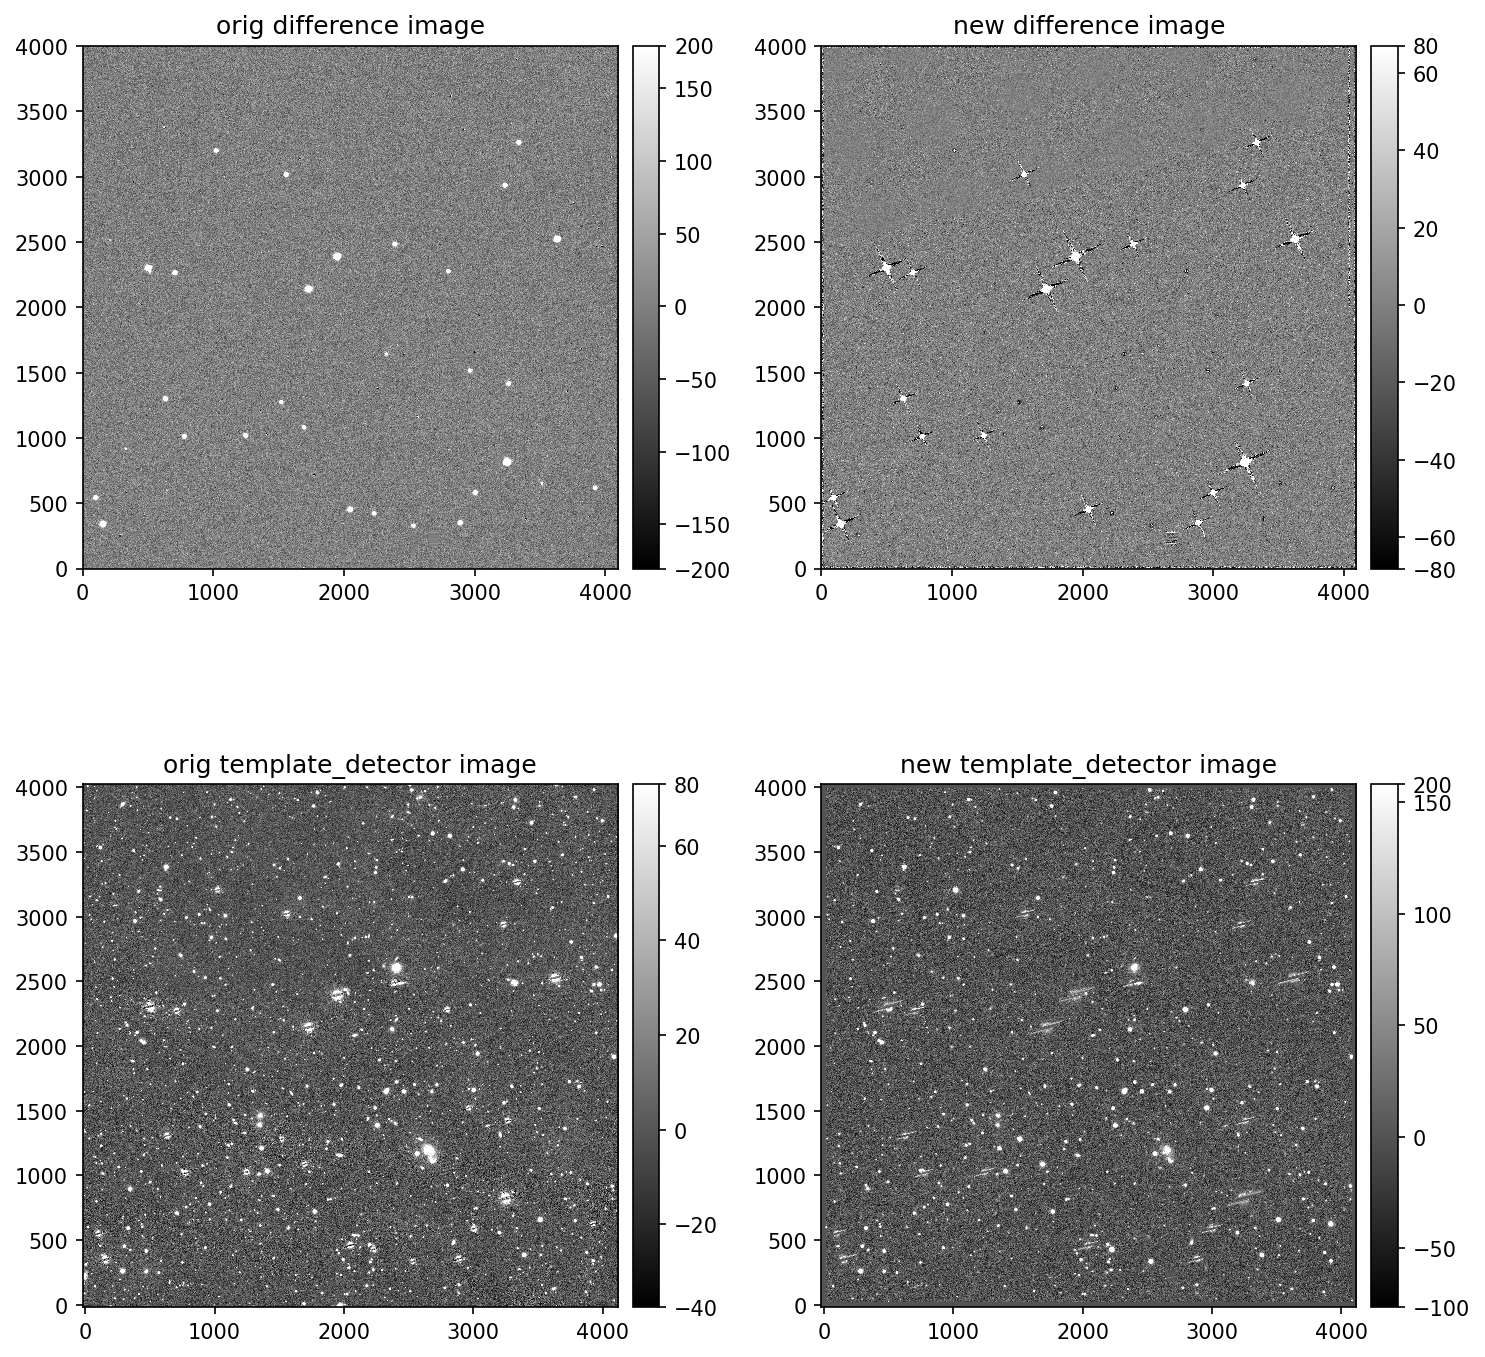

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=150)

plt.sca(ax[0, 0])
display0 = afw_display.Display(frame=fig)
display0.scale('linear', 'zscale')
display0.mtv(orig_diffim.image)
plt.title('orig difference image')

plt.sca(ax[0, 1])
display1 = afw_display.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(new_diffim.image)
plt.title('new difference image')

plt.sca(ax[1, 0])
display2 = afw_display.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(orig_template_det.image)
plt.title('orig template_detector image')

plt.sca(ax[1, 1])
display3 = afw_display.Display(frame=fig)
display3.scale('linear', 'zscale')
display3.mtv(new_template_det.image)
plt.title('new template_detector image')

plt.tight_layout()
plt.show()

## Result

We have confirmed that the DMS can perform difference imaging of single visits, and that the resulting difference image is well-formed. The result of this test is a **Pass**.